In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE  # For data balancing

In [28]:
# Load dataset
data = pd.read_excel('Heart_Disease.xlsx')

In [29]:
# Show the first few rows
data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3,30,No,Female,55-59,White,Yes,Yes,Very good,5,Yes,No,Yes
1,No,20.34,No,No,Yes,0,0,No,Female,80 or older,White,No,Yes,Very good,7,No,No,No
2,No,26.58,Yes,No,No,20,30,No,Male,65-69,White,Yes,Yes,Fair,8,Yes,No,No
3,No,24.21,No,No,No,0,0,No,Female,75-79,White,No,No,Good,6,No,No,Yes
4,No,23.71,No,No,No,28,0,Yes,Female,40-44,White,No,Yes,Very good,8,No,No,No


In [30]:
# Check for duplicates
data.duplicated().sum()

18078

In [31]:
# Remove duplicates
data.drop_duplicates(inplace=True)

In [32]:
# Check basic statistics
data.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,301717.000000,301717.000000,301717.000000,301717.000000
mean,28.441970,3.572298,4.121475,7.084559
std,6.468134,8.140656,8.128288,1.467122
min,12.020000,0.000000,0.000000,1.000000
25%,24.030000,0.000000,0.000000,6.000000
50%,27.410000,0.000000,0.000000,7.000000
75%,31.650000,2.000000,4.000000,8.000000
max,94.850000,30.000000,30.000000,24.000000


In [33]:
# Check data types and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301717 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      301717 non-null  object 
 1   BMI               301717 non-null  float64
 2   Smoking           301717 non-null  object 
 3   AlcoholDrinking   301717 non-null  object 
 4   Stroke            301717 non-null  object 
 5   PhysicalHealth    301717 non-null  int64  
 6   MentalHealth      301717 non-null  int64  
 7   DiffWalking       301717 non-null  object 
 8   Sex               301717 non-null  object 
 9   AgeCategory       301717 non-null  object 
 10  Race              301717 non-null  object 
 11  Diabetic          301717 non-null  object 
 12  PhysicalActivity  301717 non-null  object 
 13  GenHealth         301717 non-null  object 
 14  SleepTime         301717 non-null  int64  
 15  Asthma            301717 non-null  object 
 16  KidneyDisease     301717 

In [34]:
# Check missing values
print("Missing values:\n", data.isnull().sum())

Missing values:
 HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64


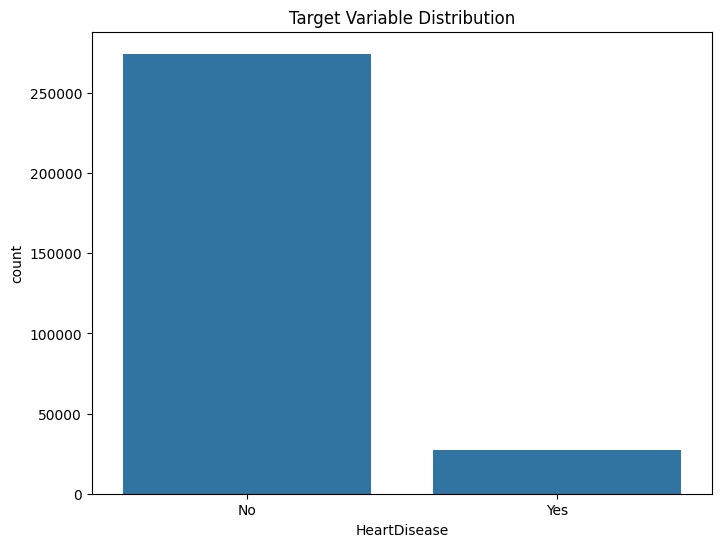

In [35]:
# Visualize the target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='HeartDisease', data=data)
plt.title("Target Variable Distribution")
plt.show()

In [36]:
# Convert categorical data to numerical data
labelencoder = LabelEncoder()
for col in ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'HeartDisease', 'Sex', 'Diabetic', 
            'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer', 'GenHealth', 'Race']:
    data[col] = labelencoder.fit_transform(data[col])

In [37]:
# Handle AgeCategory (convert ranges to numeric values)
def convert_age_to_numeric(age_range):
    if '80 or older' in age_range:
        return 80
    else:
        start, end = map(int, age_range.split('-'))
        return (start + end) / 2

In [38]:
# Apply conversion to the 'AgeCategory' column
data['AgeCategory'] = data['AgeCategory'].apply(convert_age_to_numeric).astype(int)

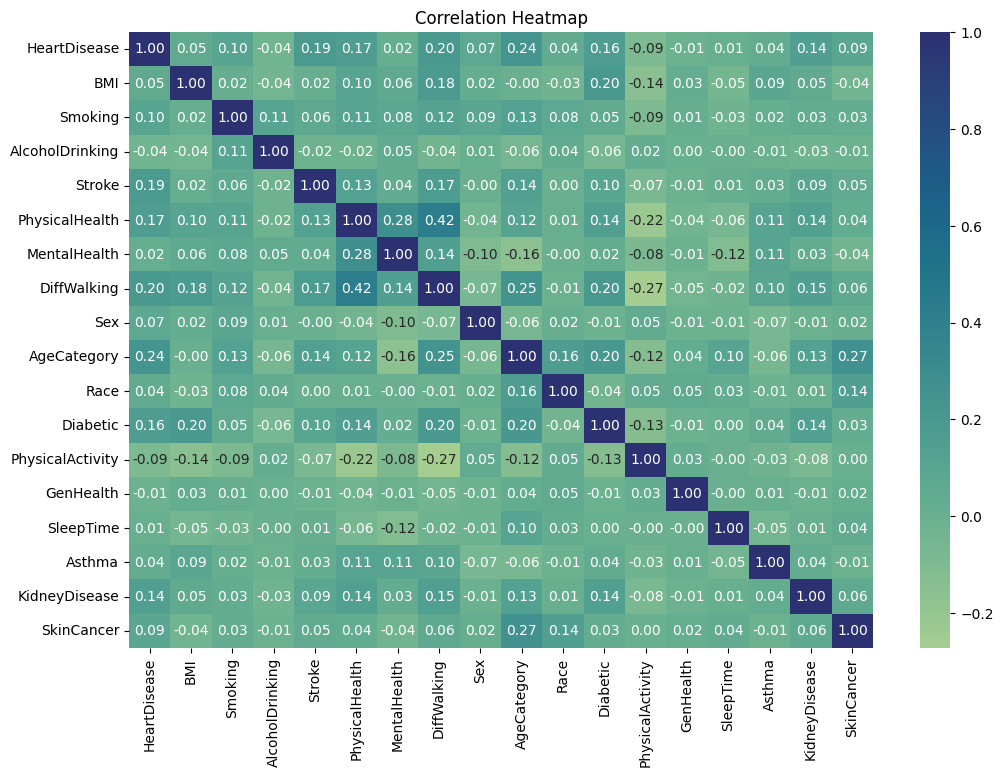

In [55]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='crest', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [47]:
# Calculate Q1 and Q3 (the first and third quartiles)
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Set bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers
outliers = ((data < lower_bound) | (data > upper_bound)).sum(axis=0)
print("Outliers detected per feature:\n", outliers)

Outliers detected per feature:
 HeartDisease        27261
BMI                  8905
Smoking                 0
AlcoholDrinking     21581
Stroke              12064
PhysicalHealth      47136
MentalHealth        39713
DiffWalking         44355
Sex                     0
AgeCategory             0
Race                73993
Diabetic            49921
PhysicalActivity    71305
GenHealth               0
SleepTime            4542
Asthma              42651
KidneyDisease       11776
SkinCancer          29292
dtype: int64


In [40]:
# Separate features and target variable
X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']

In [41]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

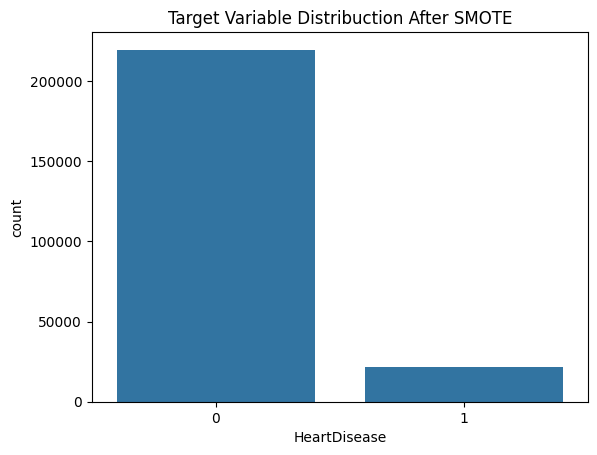

In [ ]:
sns.countplot(x=y_train)
plt.title("Target Variable Distribuction Before SMOTE")
plt.show()

In [42]:
# Apply SMOTE to the training data to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

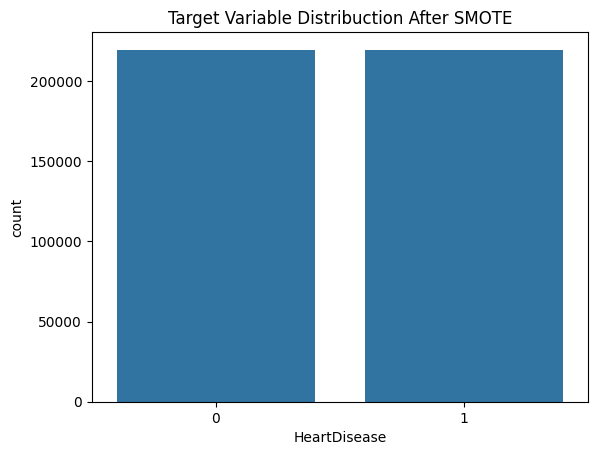

In [48]:
sns.countplot(x=y_train_resampled)
plt.title("Target Variable Distribuction After SMOTE")
plt.show()

In [43]:
# Feature Scaling
scaler = StandardScaler()

In [44]:
# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train_resampled)
# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

Model Training and Evaluation

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=0.1),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10),
    "Decision Tree": DecisionTreeClassifier(max_depth=5)
}


Model: Logistic Regression
Accuracy     : 0.6995
Precision    : 0.1820
Recall       : 0.6661
F1-Score     : 0.2859
ROC AUC      : 0.6844
Cross-validation scores: [0.70383148 0.75072018 0.75099345 0.75008255 0.75189014]
Mean cross-validation score: 0.7415


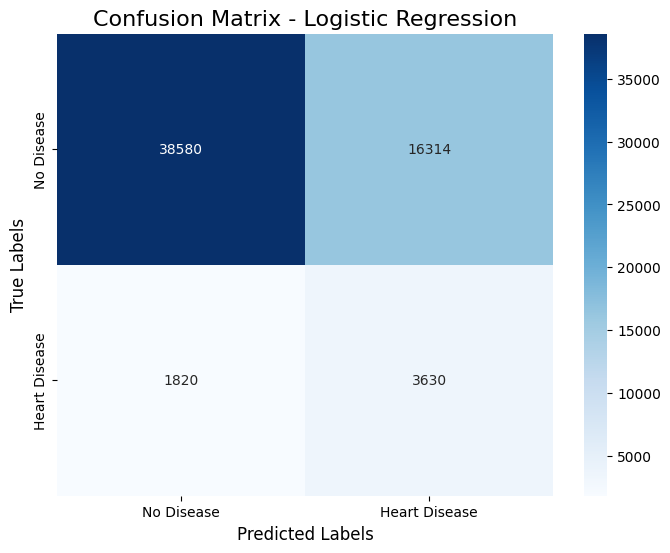


Model: Random Forest
Accuracy     : 0.6968
Precision    : 0.1952
Recall       : 0.7547
F1-Score     : 0.3101
ROC AUC      : 0.7229
Cross-validation scores: [0.74493595 0.763154   0.76444065 0.76142328 0.76235425]
Mean cross-validation score: 0.7593


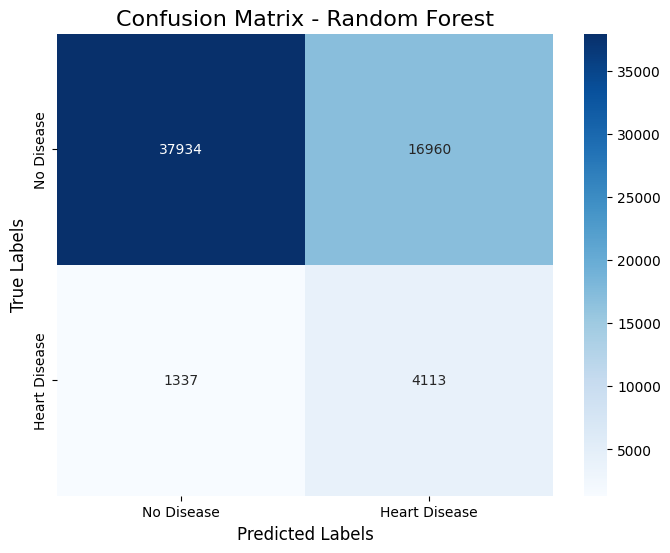


Model: Decision Tree
Accuracy     : 0.6526
Precision    : 0.1797
Recall       : 0.7987
F1-Score     : 0.2935
ROC AUC      : 0.7184
Cross-validation scores: [0.7275491  0.75409052 0.74877313 0.74925135 0.75422436]
Mean cross-validation score: 0.7468


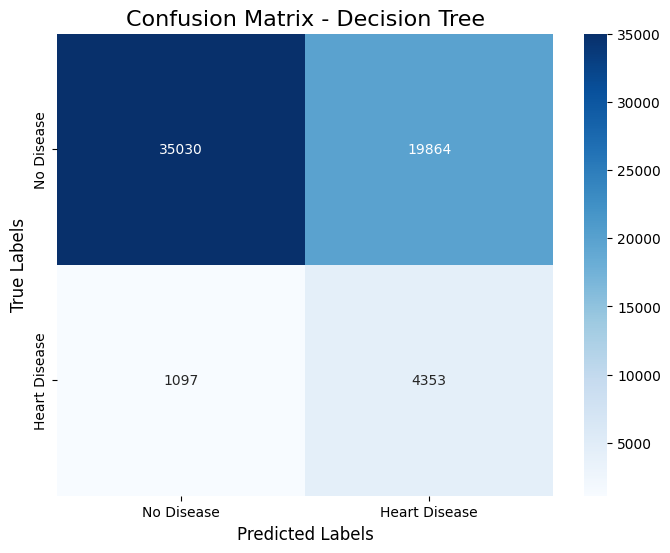

In [53]:
# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train_resampled)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    # Print metrics
    print(f"\nModel: {model_name}")
    print(f"{'='*30}")
    print(f"Accuracy     : {accuracy:.4f}")
    print(f"Precision    : {precision:.4f}")
    print(f"Recall       : {recall:.4f}")
    print(f"F1-Score     : {f1:.4f}")
    print(f"ROC AUC      : {auc:.4f}")
    print(f"{'='*30}")
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train_scaled, y_train_resampled, cv=5)
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean cross-validation score: {cv_scores.mean():.4f}")
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Plotting the Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["No Disease", "Heart Disease"], 
                yticklabels=["No Disease", "Heart Disease"])
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16)
    plt.ylabel('True Labels', fontsize=12)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()